# Tugas Prapraktikum

Tugas Prapraktikum dikerjakan dengan _dataset_ [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/download?datasetVersionNumber=2). Tanpa meninjau waktu (`date`), prediksi status hujan pada keesokan harinya (`RainTomorrow`). Berikan nilai `1` jika diprediksi hujan pada keesokan harinya, `0` jika tidak.

<br>
Tugas dikerjakan secara berkelompok. Setiap kelompok terdiri atas 2 (dua) mahasiswa. Kumpulkan paling lambat pada Minggu, 16 April 2023, pukul 23:59 WIB melalui Edunex.

# 0. Persiapan Data and Pustaka

In [1]:
# Letakkan pustaka di sini.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


In [2]:
# Baca data di sini.
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# I. Pemahaman Data
Tujuan dari bagian ini adalah peserta dapat memahami kualitas dari data yang diberikan. Hal yang diliputi adalah sebagai berikut:
1. Ukuran data
2. Statistik dari tiap fitur
3. Pencilan (_outlier_)
4. Korelasi
5. Distribusi 

## I.1 
Carilah:
1. Ukuran dari data (instansi dan fitur)
2. Tipe dari setiap fitur 
3. Banyak nilai unik dari fitur yang bertipe kategorikal
4. Nilai minimum, maksimum, rata-rata, median, dan standar deviasi dari fitur nonkategorikal

In [3]:
# I.1 Kode di sini.
# 1. Ukuran data
print("Ukuran data  : ", df.shape)
print("Fitur        : ", df.columns)

Ukuran data  :  (145460, 23)
Fitur        :  Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')


In [4]:
# 2. Tipe setiap fitur
print(df.dtypes)

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object


In [5]:
# 3. Banyak nilai unik dari fitur kategorikal
categorical_columns = df.columns[df.dtypes == 'object']
print("Kolom kategorikal :", categorical_columns)
print("Banyak nilai unik setiap kolom kategorikal :")
for col in categorical_columns:
    print(col, ":", df[col].unique())

Kolom kategorikal : Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm',
       'RainToday', 'RainTomorrow'],
      dtype='object')
Banyak nilai unik setiap kolom kategorikal :
Date : ['2008-12-01' '2008-12-02' '2008-12-03' ... '2008-01-29' '2008-01-30'
 '2008-01-31']
Location : ['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']
WindGustDir : ['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' nan 'ENE' 'SSE' 'S' 'NW' 'SE'
 'ESE' 'E' 'SSW']
WindDir9am : ['W'

In [6]:
# 4. Nilai minimum, maksimum, rata-rata, median, std fitur numerik
numerical_columns = df.columns[df.dtypes != 'object']
print("Kolom numerikal :", numerical_columns)
print("\nNilai minimum, maksimum, rata-rata, median, std fitur numerik :")
for col in numerical_columns:
    print(col, ":\n\tMinimum:", df[col].min(), "\n\tMaksimum:", df[col].max(), "\n\tRata-rata:", df[col].mean(), "\n\tMedian", df[col].median(), "\n\tSTD:", df[col].std(), "\n")

Kolom numerikal : Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm'],
      dtype='object')

Nilai minimum, maksimum, rata-rata, median, std fitur numerik :
MinTemp :
	Minimum: -8.5 
	Maksimum: 33.9 
	Rata-rata: 12.19403438096892 
	Median 12.0 
	STD: 6.398494975663227 

MaxTemp :
	Minimum: -4.8 
	Maksimum: 48.1 
	Rata-rata: 23.22134827564685 
	Median 22.6 
	STD: 7.119048845979134 

Rainfall :
	Minimum: 0.0 
	Maksimum: 371.0 
	Rata-rata: 2.3609181499166656 
	Median 0.0 
	STD: 8.478059737726372 

Evaporation :
	Minimum: 0.0 
	Maksimum: 145.0 
	Rata-rata: 5.468231522922462 
	Median 4.8 
	STD: 4.1937040941517845 

Sunshine :
	Minimum: 0.0 
	Maksimum: 14.5 
	Rata-rata: 7.6111775206611565 
	Median 8.4 
	STD: 3.7854829647401664 

WindGustSpeed :
	Minimum: 6.0 
	Maksimum: 135.0 
	Rata-rata: 40.0352300716

In [7]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [8]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


## I.2
Carilah:
1. Nilai hilang (_missing_) dari setiap fitur
2. Nilai pencilan (_outlier_) dari setiap fitur

In [9]:
# I.2 Kode di sini.
# 1. Missing value setiap fitur
print("Jumlah missing value: ")
for col in df.columns:
    print(col, ":", df[col].isnull().sum())

# 2. Outlier setiap fitur
print("\nJumlah outlier setiap fitur: ")
for col in numerical_columns:
    # get IQR
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    # get outlier
    print(col, ":", df[(df[col] < q1 - 1.5 * iqr) | (df[col] > q3 + 1.5 * iqr)].shape[0])

Jumlah missing value: 
Date : 0
Location : 0
MinTemp : 1485
MaxTemp : 1261
Rainfall : 3261
Evaporation : 62790
Sunshine : 69835
WindGustDir : 10326
WindGustSpeed : 10263
WindDir9am : 10566
WindDir3pm : 4228
WindSpeed9am : 1767
WindSpeed3pm : 3062
Humidity9am : 2654
Humidity3pm : 4507
Pressure9am : 15065
Pressure3pm : 15028
Cloud9am : 55888
Cloud3pm : 59358
Temp9am : 1767
Temp3pm : 3609
RainToday : 3261
RainTomorrow : 3267

Jumlah outlier setiap fitur: 
MinTemp : 54
MaxTemp : 489
Rainfall : 25578
Evaporation : 1995
Sunshine : 0
WindGustSpeed : 3092
WindSpeed9am : 1817
WindSpeed3pm : 2523
Humidity9am : 1425
Humidity3pm : 0
Pressure9am : 1191
Pressure3pm : 919
Cloud9am : 0
Cloud3pm : 0
Temp9am : 262
Temp3pm : 764


## I.3
Lakukan:
1. Pencarian korelasi antarfitur
2. Visualisasi distribusi setiap fitur (kategorikal dan kontinu)
3. Visualisasi distribusi setiap fitur per target (`RainTomorrow`)

In [10]:
# I.3 Kode di sini.
# 1. Korelasi antarfitur
print("Korelasi antarfitur:")
df.corr()

Korelasi antarfitur:


C:\Users\Rani\AppData\Local\Temp\ipykernel_37608\529950899.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
MinTemp,1.000000,0.736555,0.103938,0.466993,0.072586,0.177415,0.175064,0.175173,-0.232899,0.006089,-0.450970,-0.461292,0.078754,0.021605,0.901821,0.708906
MaxTemp,0.736555,1.000000,-0.074992,0.587932,0.470156,0.067615,0.014450,0.050300,-0.504110,-0.508855,-0.332061,-0.427167,-0.289370,-0.277921,0.887210,0.984503
Rainfall,0.103938,-0.074992,1.000000,-0.064351,-0.227549,0.133659,0.087338,0.057887,0.224405,0.255755,-0.168154,-0.126534,0.198528,0.172403,0.011192,-0.079657
Evaporation,0.466993,0.587932,-0.064351,1.000000,0.365602,0.203021,0.193084,0.129400,-0.504092,-0.390243,-0.270362,-0.293581,-0.183793,-0.182618,0.545115,0.572893
Sunshine,0.072586,0.470156,-0.227549,0.365602,1.000000,-0.034750,0.005499,0.053834,-0.490819,-0.629130,0.041970,-0.019719,-0.675323,-0.703930,0.291188,0.490501
WindGustSpeed,0.177415,0.067615,0.133659,0.203021,-0.034750,1.000000,0.605303,0.686307,-0.215070,-0.026327,-0.458744,-0.413749,0.071736,0.109168,0.150150,0.032748
WindSpeed9am,0.175064,0.014450,0.087338,0.193084,0.005499,0.605303,1.000000,0.519547,-0.270858,-0.031614,-0.228743,-0.175817,0.025112,0.054639,0.128545,0.004569
WindSpeed3pm,0.175173,0.050300,0.057887,0.129400,0.053834,0.686307,0.519547,1.000000,-0.145525,0.016432,-0.296351,-0.255439,0.053337,0.025396,0.163030,0.027778
Humidity9am,-0.232899,-0.504110,0.224405,-0.504092,-0.490819,-0.215070,-0.270858,-0.145525,1.000000,0.666949,0.139442,0.186858,0.452297,0.357326,-0.471354,-0.498399
Humidity3pm,0.006089,-0.508855,0.255755,-0.390243,-0.629130,-0.026327,-0.031614,0.016432,0.666949,1.000000,-0.027544,0.051997,0.517120,0.523120,-0.221019,-0.557841


C:\Users\Rani\AppData\Local\Temp\ipykernel_37608\2484476080.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plot = sns.heatmap(df.corr(), annot=True, fmt='.2f', linewidths=.5)


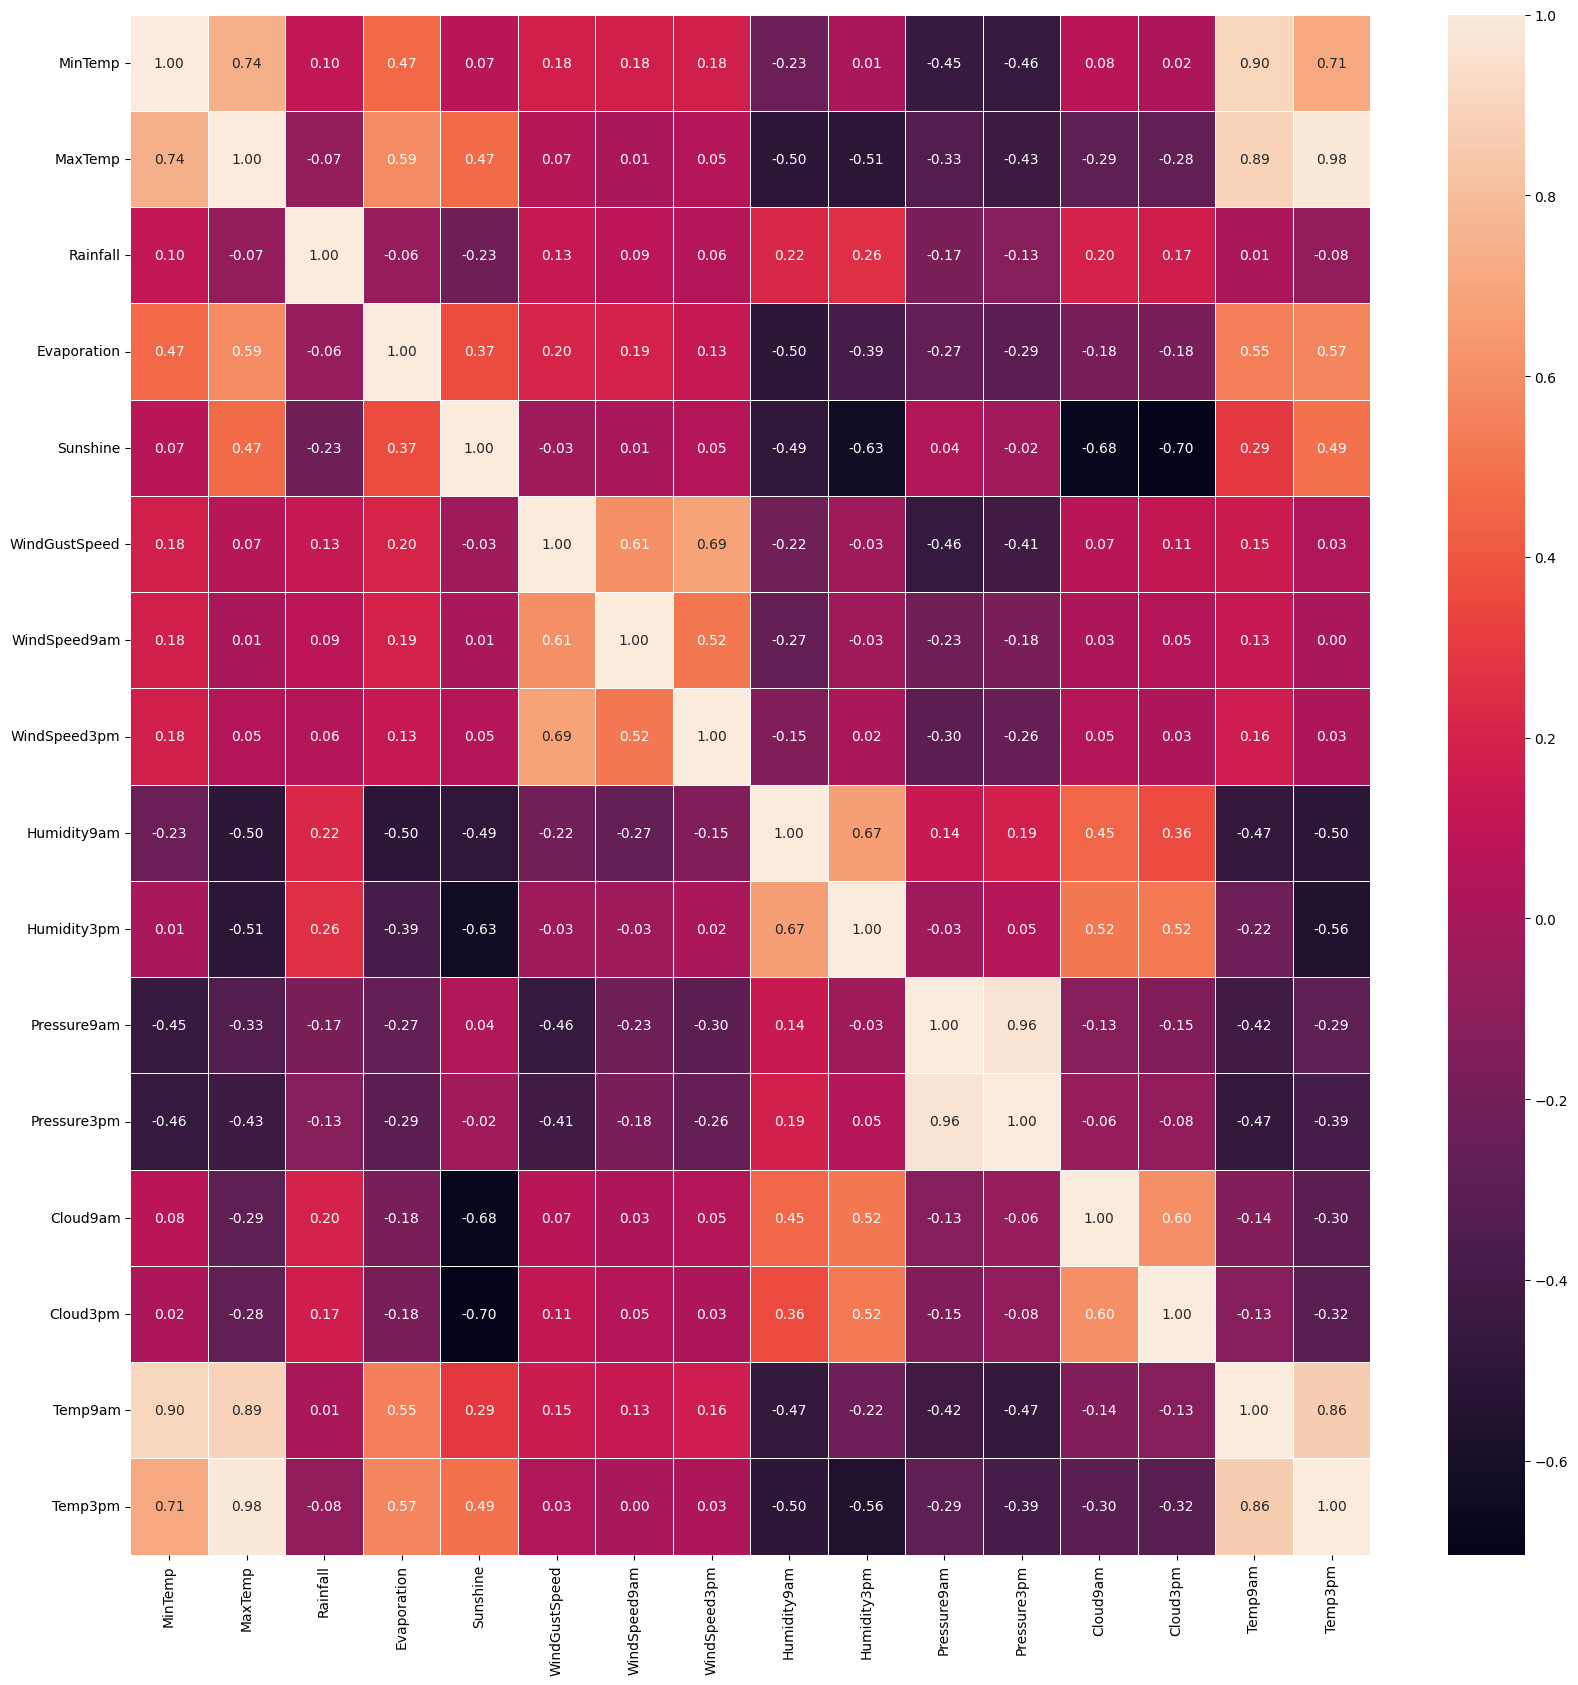

In [11]:
#   Visualisasi korelasi antarfitur
plt.figure(figsize=(20, 20))
plot = sns.heatmap(df.corr(), annot=True, fmt='.2f', linewidths=.5)
plt.show()

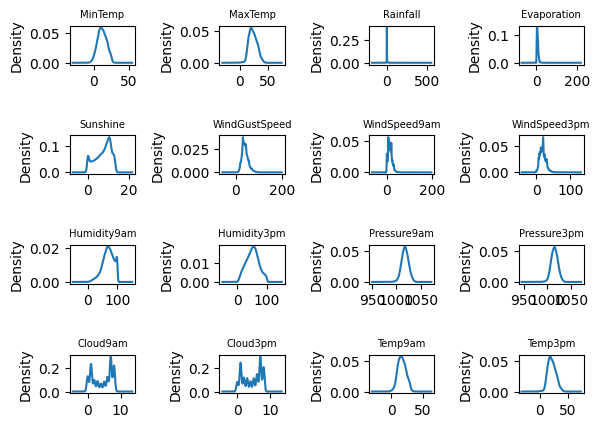

<Figure size 2000x2000 with 0 Axes>

In [12]:
# 2. Visualisasi distribusi setiap fitur
col_num = 4
row_num = len(numerical_columns) // col_num

fig, axs = plt.subplots(row_num, col_num)
fig.tight_layout(pad=3.0)
plt.figure(figsize=(20, 20))
# set font size
plt.rcParams.update({'font.size': 6})

col_cnt = 0
row_cnt = 0

for col in numerical_columns:
    df[col].plot.kde(ax=axs[row_cnt, col_cnt])
    axs[row_cnt, col_cnt].set_title(col)
    col_cnt += 1
    if col_cnt == col_num:
        col_cnt = 0
        row_cnt += 1

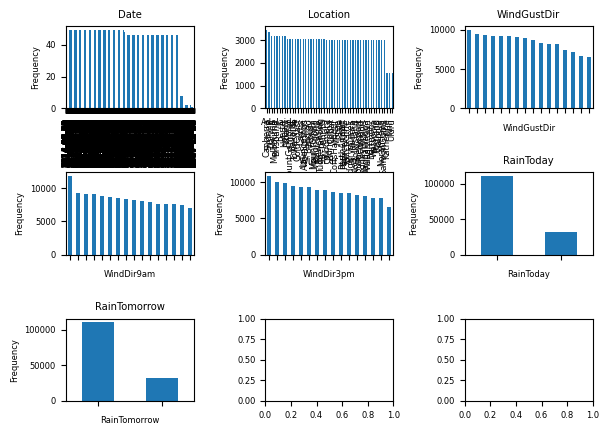

<Figure size 3000x3000 with 0 Axes>

In [13]:
col_num = 3
row_num = len(categorical_columns) // col_num + 1

fig, axs = plt.subplots(row_num, col_num)
fig.tight_layout(pad=5.0)
plt.figure(figsize=(30, 30))
# set font size
plt.rcParams.update({'font.size': 6})

col_cnt = 0
row_cnt = 0

for col in categorical_columns:
    # Plot frequency bar chart
    df[col].value_counts().plot(kind='bar', ax=axs[row_cnt, col_cnt])
    axs[row_cnt, col_cnt].set_title(col)
    axs[row_cnt, col_cnt].set_xlabel(col)
    axs[row_cnt, col_cnt].set_ylabel('Frequency')
    # disable label for col "Date" and "Location"
    if col != "Date" and col != "Location":
        axs[row_cnt, col_cnt].set_xticklabels([])
        
    col_cnt += 1
    if col_cnt == col_num:
        col_cnt = 0
        row_cnt += 1

plt.show()

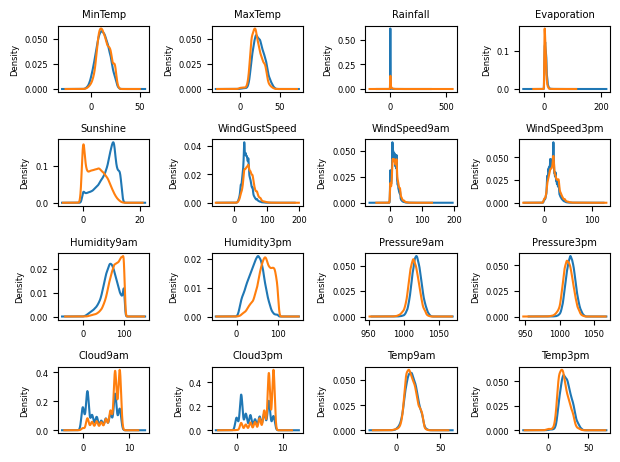

<Figure size 2000x2000 with 0 Axes>

In [14]:
# 3. Visualisasi distribusi setiap fitur per RainTomorrow
col_num = 4
row_num = len(numerical_columns) // col_num

fig, axs = plt.subplots(row_num, col_num)
fig.tight_layout(pad=3.0)
plt.figure(figsize=(20, 20))
# set font size
plt.rcParams.update({'font.size': 6})

col_cnt = 0
row_cnt = 0

for col in numerical_columns:
    df.groupby('RainTomorrow')[col].plot.kde(ax=axs[row_cnt, col_cnt])
    axs[row_cnt, col_cnt].set_title(col)
    col_cnt += 1
    if col_cnt == col_num:
        col_cnt = 0
        row_cnt += 1

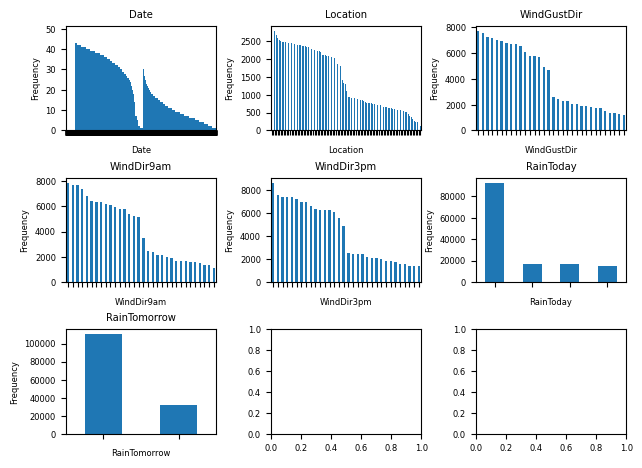

<Figure size 2000x2000 with 0 Axes>

In [15]:
col_num = 3
row_num = len(categorical_columns) // col_num + 1

fig, axs = plt.subplots(row_num, col_num)
# padding x = 3, padding y = 5
fig.tight_layout(pad=3.0)
plt.figure(figsize=(20, 20))
# set font size
plt.rcParams.update({'font.size': 6})

col_cnt = 0
row_cnt = 0

for col in categorical_columns:
    df.groupby('RainTomorrow')[col].value_counts().plot(kind='bar', ax=axs[row_cnt, col_cnt])
    axs[row_cnt, col_cnt].set_title(col)
    axs[row_cnt, col_cnt].set_xlabel(col)
    axs[row_cnt, col_cnt].set_ylabel('Frequency')
    # remove x label because it's to crowded
    axs[row_cnt, col_cnt].set_xticklabels([]) 


    col_cnt += 1
    if col_cnt == col_num:
        col_cnt = 0
        row_cnt += 1

## I.4
Lakukanlah analisis lebih lanjut jika diperlukan, kemudian lakukan hal berikut:
1. Penambahan fitur jika memungkinkan
2. Pembuangan fitur yang menurut kalian tidak dibutuhkan
3. Penanganan nilai hilang
4. Transformasi data kategorikal menjadi numerikal (_encoding_)
5. _Scaling_ dengan `MinMaxScaler`

In [16]:
# I.4 Put your code here
# 1. Add new feature

# Split Date to Year, Month, and Day
df['Year'] = df['Date'].apply(lambda x: int(x.split('-')[0]))
df['Month'] = df['Date'].apply(lambda x: int(x.split('-')[1]))
df['Day'] = df['Date'].apply(lambda x: int(x.split('-')[2]))

# 2. Drop feature
df = df.drop(columns=['Date'])

In [17]:
# 3. Impute missing value
df.fillna(df.mode(), inplace=True)
df.dropna(inplace=True)

In [18]:
# 4. Encode categorical feature
# a. Manual encoding

categorical_columns = df.columns[df.dtypes == 'object']
categorical_columns = [x for x in categorical_columns if x != 'RainTomorrow']
print(categorical_columns)
numerical_columns = df.columns[df.dtypes != 'object']

def encode(df, variable, labels):
    for label in labels:
        df[variable+'_'+str(label)] = np.where(df[variable]==label,1,0)
    return df

for cat_col in categorical_columns:
    print(cat_col)
    df = encode(df, cat_col, df[cat_col].unique())

df = df.drop(columns=categorical_columns)
df = df.drop(columns=numerical_columns)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder().fit(df['RainTomorrow'])
df['RainTomorrow'] = le.fit_transform(df['RainTomorrow'])

# b. Dummy encoding
# df = pd.get_dummies(df, columns=categorical_columns)

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
Location
WindGustDir
WindDir9am
WindDir3pm
RainToday


In [19]:
# 5. Scaling data
numerical_columns = df.columns[df.dtypes != 'object']
categorical_columns = df.columns[df.dtypes == 'object']

norm = MinMaxScaler().fit(df[numerical_columns])
df_norm = norm.transform(df[numerical_columns])
df = pd.concat([df.drop(columns=numerical_columns), pd.DataFrame(df_norm, columns=numerical_columns)], axis=1)

# II. Desain Eksperimen
Tujuan dari bagian ini adalah peserta dapat memahami cara melakukan eksperimen mencari metode terbaik dengan benar. Hal yang diliputi adalah sebagai berikut:
1. Pembuatan model
2. Proses validasi
3. _Hyperparameter tuning_

## II.1
Tentukanlah metrik yang akan digunakan pada eksperimen kali ini. Metrik yang dapat lebih dari satu jenis.

Target prediksi (`RainTomorrow`) memiliki domain ['Yes', 'No'] sehingga task ini merupakan binary classification.

Disini, ada 2 kemungkinan metrics yang dapat digunakan.

Dengan asumsi bahwa semua kelas dianggap equally important dan true positive dan false positive dirasa sama-sama pentingnya, pakai ROC-AUC.

Kalau lebih mementingkan, siapa yang berpotensi jelek langsung prediksi jelek saja, digunakan recall. Untuk menyeimbangkan recall, dipakai precision. Untuk mengukur keduanya dengan lebih baik, digunakan F1 score, yang merupakan harmonic balance of precision and recall.

Oleh karena itu, akan digunakan dua metrics, yakni F1 score dan ROC-AUC.

In [20]:
# Cek imbalance
print("Jumlah data RainTomorrow Yes :", df[df['RainTomorrow'] == 'Yes'].shape[0])
print("Jumlah data RainTomorrow No :", df[df['RainTomorrow'] == 'No'].shape[0])

Jumlah data RainTomorrow Yes : 0
Jumlah data RainTomorrow No : 0


## II.2 
Bagi data dengan perbandingan 0,8 untuk data latih dan 0,2 untuk data validasi.

In [21]:
df = df.dropna()

In [22]:
# II.2 Kode di sini
X, y = df.copy(deep=True).drop(columns=['RainTomorrow']), df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## II.3
Lakukan hal berikut:
1. Prediksi dengan menggunakan model _logistic regression_ sebagai _baseline_.
2. Tampilkan evaluasi dari model yang dibangun dari metrik yang ditentukan pada II.1
3. Tampilkan _confusion matrix_.

In [23]:
X_train.isna().sum()

Location_Albury           0
Location_Cobar            0
Location_CoffsHarbour     0
Location_Moree            0
Location_NorfolkIsland    0
                         ..
WindDir3pm_NE             0
WindDir3pm_SSW            0
WindDir3pm_W              0
RainToday_No              0
RainToday_Yes             0
Length: 77, dtype: int64

In [24]:
# II.3 Kode di sini
# 1. Model Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [25]:
# 2. Evaluasi model
y_pred = logreg.predict(X_test)
print(f1_score(y_test, y_pred, average='macro'))
print(roc_auc_score(y_test, y_pred))

0.5845711767884865
0.5771492832121122


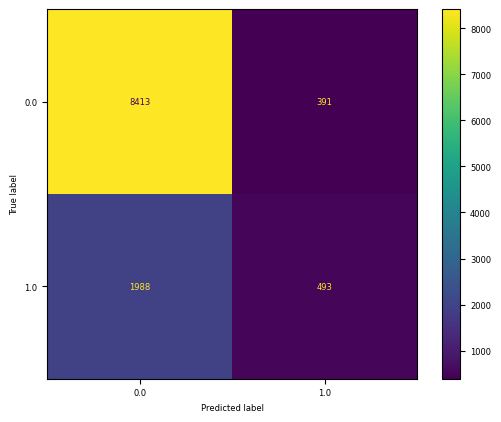

In [26]:
# 3. Confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=logreg.classes_).plot()

## II.4 
Lakukanlah:
1. Pembelajaran dengan model lain
2. _Hyperparameter tuning_ untuk model yang dipakai dengan menggunakan _grid search_ (perhatikan _random factor_ pada beberapa algoritma model)
3. Validasi dengan _cross validation_


In [27]:
# II.4 Kode di sini.
# 1. Model XGBoost
XGBClf = XGBClassifier()
XGBClf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [36]:
# 2. Hyperparameter
# Gradient Boosting Regressor
parameters = {  "learning_rate":[0.1, 0.01],
                "max_depth" : [None, 1, 3, 5],
                'init': [None],
                'n_estimators': [100],
                'n_iter_no_change': [None],
                'random_state': [42],
                'subsample': [1.0],
                }

hyperparam_tuning = GridSearchCV(XGBClf, param_grid = parameters, scoring='f1_macro', cv=2, verbose=3)
hyperparam_tuning.fit(X_train, y_train)
hyperparam_tuning.best_params_

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END init=None, learning_rate=0.1, max_depth=None, n_estimators=100, n_iter_no_change=None, random_state=42, subsample=1.0;, score=0.607 total time=   1.0s
[CV 2/2] END init=None, learning_rate=0.1, max_depth=None, n_estimators=100, n_iter_no_change=None, random_state=42, subsample=1.0;, score=0.600 total time=   0.9s
[CV 1/2] END init=None, learning_rate=0.1, max_depth=1, n_estimators=100, n_iter_no_change=None, random_state=42, subsample=1.0;, score=0.498 total time=   0.3s
[CV 2/2] END init=None, learning_rate=0.1, max_depth=1, n_estimators=100, n_iter_no_change=None, random_state=42, subsample=1.0;, score=0.495 total time=   0.4s
[CV 1/2] END init=None, learning_rate=0.1, max_depth=3, n_estimators=100, n_iter_no_change=None, random_state=42, subsample=1.0;, score=0.568 total time=   0.5s
[CV 2/2] END init=None, learning_rate=0.1, max_depth=3, n_estimators=100, n_iter_no_change=None, random_state=42, subsample=1.0;,

{'init': None,
 'learning_rate': 0.1,
 'max_depth': None,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0}

In [37]:
XGBClf = XGBClassifier( learning_rate=0.1,
                        max_depth=None,
                        n_estimators=100,
                        n_iter_no_change=None,
                        random_state=42,
                        subsample=1.0 )
XGBClf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_iter_no_change=None, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [38]:
# 3. Cross validation

scores = cross_validate(XGBClf, X, y, scoring=['f1_macro', 'roc_auc'], cv=5, return_train_score=True)
print(scores.keys())
print("ROC-AUC: %0.2f (+/- %0.2f)" % (scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))
print("F1 Score: %0.2f (+/- %0.2f)" % (scores['test_f1_macro'].mean(), scores['test_f1_macro'].std()))

dict_keys(['fit_time', 'score_time', 'test_f1_macro', 'train_f1_macro', 'test_roc_auc', 'train_roc_auc'])
ROC-AUC: 0.66 (+/- 0.08)
F1 Score: 0.55 (+/- 0.04)


# III. Improvement
Pada bagian ini, kalian diharapkan dapat:
1. melakukan pelatihan dengan data hasil _oversampling_ / _undersampling_, disertai dengan validasi yang benar; serta
2. menerapkan beberapa metode untuk menggabungkan beberapa model.

Kedua hal ini adalah contoh metode untuk meningkatkan kinerja dari model.

## III.1
Lakukanlah:
1. _Oversampling_ pada kelas minoritas pada data latih
2. _Undersampling_ pada kelas mayoritas pada data latih

Pada setiap tahap, latih dengan model *baseline* (II.3), dan validasi dengan data validasi. Data latih dan validasi adalah data yang disusun pada bagian II.2.

In [39]:
# III.1 Kode di sini.
# Random oversampling
oversampler = RandomOverSampler(random_state=42, sampling_strategy='minority')

X_oversample, y_oversample = oversampler.fit_resample(X_train, y_train)

logreg.fit(X_oversample, y_oversample)
y_pred = logreg.predict(X_test)
print(f1_score(y_test, y_pred, average='macro'))
print(roc_auc_score(y_test, y_pred))

0.6396410532660944
0.6719313946374087


In [40]:
# Random undersampling
undersampler = RandomUnderSampler(random_state=42, sampling_strategy='majority')

X_undersample, y_undersample = undersampler.fit_resample(X_train, y_train)

logreg.fit(X_undersample, y_undersample)
y_pred = logreg.predict(X_test)
print(f1_score(y_test, y_pred, average='macro'))
print(roc_auc_score(y_test, y_pred))

0.639944872246915
0.6720706171995764


## III.2
Lakukanlah:
1. Eksplorasi _soft voting_, _hard voting_, dan _stacking_.
2. Buatlah model _logistic regression_ dan SVM.
3. Lakukanlah _soft voting_ dari model-model yang dibangun pada poin 2.
4. Lakukan _hard voting_ dari model-model yang dibangun pada poin 2.
5. Lakukanlah _stacking_ dengan _final classifier_ adalah _logistic regression_ dari model-model yang dibangun pada poin 2.
6. Lakukan validasi dengan metrics yang telah ditentukan untuk poin 3, 4, dan 5.

(Tuliskan hasil eksplorasi III.2 poin 1 di sini.)

In [41]:
# III.2 Kode di sini.
# 1. Library ensemble VotingClassifier
#    Soft voting: averaging the probabilities
#    Hard voting: selecting the one with greater possibility

from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.ensemble import StackingClassifier

y_pred_proba_logreg = logreg.predict_proba(X_test)

svc = SVC(probability=True)
svc.fit(X_train, y_train)
y_pred_proba_svc = svc.predict_proba(X_test)

estimators = [("logreg", logreg), ("svc", svc)]

vc_sv = VotingClassifier(estimators=estimators, voting="soft")
vc_hv = VotingClassifier(estimators=estimators, voting="hard")

kfold = KFold(n_splits=2, shuffle=True)

actual, vc_sv_predicted, vc_sv_predicted_proba = cross_val_predict(vc_sv, X, y)
actual, vc_hv_predicted, _ = cross_val_predict(vc_hv, X, y)

print(f"F1-Score of Scikit-Learn Soft Voting: {f1_score(actual, vc_sv_predicted)}")
print(f"F1-Score of Scikit-Learn Hard Voting: {f1_score(actual, vc_hv_predicted)}")

sc = StackingClassifier(estimators=estimators, final_estimator=logreg)

actual, sc_predicted, _ = cross_val_predict(sc, X, y)

print(f"F1-Score of Scikit-Learn Stacking: {f1_score(actual, sc_predicted)}")

c:\Users\Rani\Documents\Projects\ML\mlenv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# IV. Analisis
Bandingkan hasil dari hal-hal berikut:
1. Model _baseline_ (II.3)
2. Model lain (II.4)
3. Hasil _undersampling_
4. Hasil _oversampling_
5. Hasil _soft voting_
6. Hasil _hard voting_
7. Hasil _stacking_

(Tuliskan jawaban bagian IV di sini.)